In [1]:
import os

import numpy as np
import librosa
import matplotlib.pyplot as plt

import sklearn.svm
import sklearn.preprocessing as scale
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif,f_classif
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA

from tqdm.notebook import tqdm


In [12]:
root = r'\Users\39347\Progetti\CodiciPython\0CMLS\HW1\IDMT-SMT-AUDIO-EFFECTS\Gitarre monophon\class'
classes = []
fileList = []
labels = []
number_file = []

sub_dirs = [x[0] for x in os.walk(root)]

for sub_dir in sub_dirs[1:]:
    className = os.path.basename(sub_dir) # return the last term of path
    classes.append(className)
    
    prog_bar = tqdm(desc='Loading audio samples')
    prog_bar.reset(total=len(os.listdir(sub_dir))) 
    
    file_list = [f for f in os.listdir(sub_dir) if f.endswith('.wav')]
    
    for f in file_list:
        fileList.append(os.path.join(sub_dir,f))
        labels.append(className)
        prog_bar.update()
    
    number_file.append(len(os.listdir(sub_dir)))
    
    prog_bar.refresh();

np.save('classes', classes)
np.save('labels', labels)
print(number_file) 
print(classes)
len(fileList)

Loading audio samples: 0it [00:00, ?it/s]

Loading audio samples: 0it [00:00, ?it/s]

Loading audio samples: 0it [00:00, ?it/s]

[1872, 624, 1872]
['Distortion', 'NoFX', 'Tremolo']


4368

In [13]:
featureList = [
        'Average Centroid', 'Rolloff','Flatness', 'Zero crossing rate', 'Mfc1', 'Mfc2', 'Mfc3', 'Mfc4',
        'Mfc5', 'Mfc6', 'Mfc7', 'Mfc8', 'Mfc9', 'Mfc10', 'Mfc11', 'Mfc12', 'Mfc13', 'Mfc14', 'Mfc15', 'Mfc16',
        'Mfc17', 'Mfc18', 'Mfc19', 'Mfc20', 'Mfc21', 'Mel1', 'Mel2','Mel3','Mel4','Mel5','Mel6','Mel7','Mel8','Mel9',
        'Mel10','Mel11','Mel12','Mel13','Mel14','Mel15','Mel16','Mel17','Mel18','Mel19','Mel20','Mel21','Mel22','Mel23',
        'Mel24','Mel25','Mel26','Mel27','Mel28','Mel29','Mel30','Mel31','Mel32','Mel33','Mel34','Mel35','Mel36','Mel37',
        'Mel38','Mel39','Mel40','Cont1','Cont2','Cont3','Cont4','Cont5','Cont6','Cont7']

In [23]:
window_parameters={
    'n_fft': 1024,
    'hop_length': 512,
    #'win_length':2048,
    'window': 'hamming',
    'center': True
}

n_mels = 40
n_mfcc = 21

samples = len(fileList)
features = np.zeros((samples, len(featureList)))
fs_sample = np.zeros((samples,1))
min_max = np.zeros((samples,2))
length = np.zeros((samples,1))

prog_bar = tqdm(desc='Loading audio samples')
prog_bar.reset(total=samples)

for index, f in enumerate(fileList): 
    # Step1: load audio
    
    audio, fs = librosa.load(f, sr=None)
    length[index] = len(audio)
    
    fs_sample[index] = fs;
    min_max[index,0] = np.min(audio)
    min_max[index,1] = np.max(audio)
    
    # volume normalization 
    #audio = audio/(np.abs(audio).max())

    #Step2: compute features
    speCen = np.array([np.average(librosa.feature.spectral_centroid(y=audio, sr=fs, **window_parameters))])
    
    speRol = np.array([np.nanmean(np.trim_zeros(librosa.feature.spectral_rolloff(y=audio, sr=fs, **window_parameters)[0]))])
   
    speFla = np.array([np.nanmean(np.trim_zeros(librosa.feature.spectral_flatness(y=audio,
                                                 **window_parameters)[0]))])
    zcr = np.array([np.max(librosa.feature.zero_crossing_rate(y=audio,
                                                         hop_length=window_parameters.get('hop_length')))])
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=fs, **window_parameters,
                                n_mfcc=n_mfcc,norm='ortho'), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=fs, **window_parameters,
                                        n_mels=n_mels), axis = 1)
    speCon = np.mean(librosa.feature.spectral_contrast(y=audio, sr=fs, **window_parameters), axis=1)
    
    feature = np.concatenate((mel, mfcc, speCon, speCen, speRol, speFla, zcr), axis=0)
    features[index, :] = feature 
    
    prog_bar.update()
    
prog_bar.refresh();

np.save('features', features)

Loading audio samples: 0it [00:00, ?it/s]

In [28]:
features = np.load('features.npy',allow_pickle=True)
labels = np.load('labels.npy',allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

[44100.]


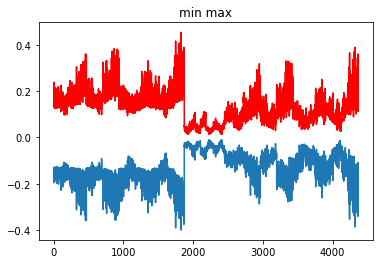

[88201.]


In [29]:
# checking dataset
print(np.unique(fs_sample))
plt.plot(min_max[:,0])
plt.plot(min_max[:,1], 'r')
plt.title('min max')
plt.show()

print(np.unique(length))

(3494, 72) (874, 72)


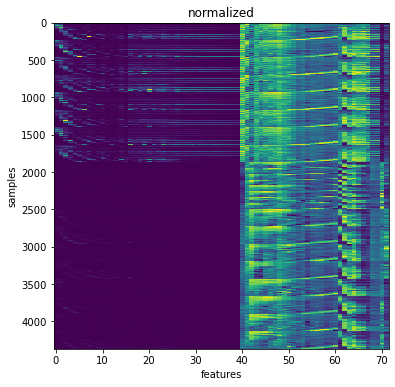

['Distortion' 'Distortion' 'Distortion' ... 'Tremolo' 'Tremolo' 'Tremolo']


In [45]:
X_train,X_test,y_train,y_test = train_test_split(features, fileLable, test_size = 0.20,random_state=10)
print(X_train.shape, X_test.shape)

#separate Normalization
mms = MinMaxScaler()
feat_norm = scale.minmax_scale(features)
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

#
plt.figure(figsize=(6, 6))
plt.imshow(feat_norm,interpolation='none')
plt.xlabel('features')
plt.ylabel('samples')
plt.axis('auto')
plt.title('normalized')
plt.show()

print(labels)
#fig.colorbar(pos, ax=ax1)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
[[4.66137456e-03 1.69778311e-01 1.65555878e-01 ... 2.75816132e-01
  9.58891159e-02 1.02249489e-01]
 [2.18531582e-02 1.69076208e-02 9.49098264e-03 ... 2.76997398e-01
  2.55485917e-01 1.53374233e-01]
 [2.15437727e-06 1.85987602e-06 2.58220373e-04 ... 3.53285605e-01
  5.57611296e-01 3.31288344e-01]
 ...
 [6.16616858e-02 3.31375603e-02 1.26682436e-02 ... 2.30090946e-01
  3.62400746e-01 1.06339468e-01]
 [5.07019112e-03 2.55892249e-04 7.34646536e-02 ... 2.67595525e-01
  7.94147358e-02 1.06339468e-01]
 [7.94068325e-04 1.77392458e-01 1.73463886e-01 ... 4.21701738e-02
  1.16121236e-03 4.90797546e-02]]
['Average Centroid' 'Rolloff' 'Flatness' 'Zero crossing rate' 'Mfc1'
 'Mfc2' 'Mfc3' 'Mfc4' 'Mfc5' 'Mfc6' 'Mfc7' 'Mfc8' 'Mfc9' 'Mfc10' 'Mfc11'
 'Mfc12' 'Mfc13' 'Mfc14' 'Mfc15' 'Mfc1

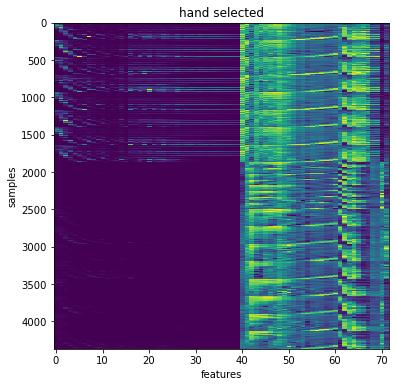

In [52]:
#SELECT K BEST
#Features selection on Training set
features_selector = SelectKBest(chi2, k=72)
X_train_sel_features = features_selector.fit_transform(X_train_norm, y_train)
selected_columns = features_selector.get_support(indices=True)
print(selected_columns)
print(X_train_sel_features)

print(np.array(featureList)[features_selector.get_support()])

X_test_sel_features = features_selector.transform(X_test_norm)
#X_test_sel_features = X_test_norm[:,selected_columns] #filtering the features in Testing set
                                                      #based on K best features computed on the Training set
features_hand = feat_norm[:,selected_columns]
print(features_hand.shape)
plt.figure(figsize=(6, 6))
plt.imshow(features_hand,interpolation='none')
plt.xlabel('features')
plt.ylabel('samples')
plt.axis('auto')
plt.title('hand selected')
plt.show()

In [53]:
#SVM Model
SVM_parameters={
    'C': 100,
    'kernel': 'rbf', #rbf, poly
    'gamma' : 1,
    'class_weight':'balanced'
    
}

ss = sklearn.svm.SVC(**SVM_parameters, probability=True)
ss.fit(X_train_sel_features, y_train)
accuracySVM = ss.score(X_test_sel_features, y_test)
print("The SVM accuracy is",format(accuracySVM))

The SVM accuracy is 0.9931350114416476


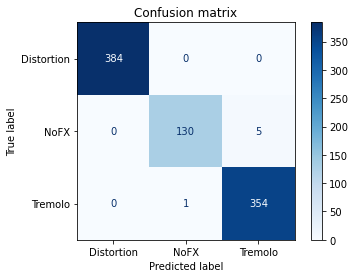

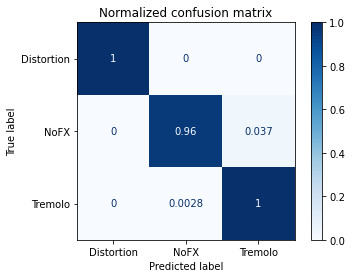

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(ss, X_test_sel_features, y_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    #print(title)
    #print(disp.confusion_matrix)

plt.show()